# Notebook for Layer-wise analysis of NLP models

In this notebook we investigate in greater details the structure of each NLP models (LSTM and transformer-based) of the ModelComparison part.

In [2]:
import warnings
warnings.simplefilter(action='ignore')

import os
import gc
import glob
import itertools
from tqdm import tqdm
from itertools import combinations
from joblib import Parallel, delayed

import umap
import scipy
import hdbscan
import nistats
import numpy as np
import pandas as pd
from sklearn import manifold
from sklearn.decomposition import PCA, FastICA
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import AgglomerativeClustering, KMeans

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nibabel as nib
import nilearn
from nilearn.image import load_img, mean_img, index_img, threshold_img, math_img, smooth_img, new_img_like
from nilearn.input_data import NiftiMapsMasker, NiftiMasker, NiftiLabelsMasker, MultiNiftiMasker
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from nilearn import datasets
from scipy.stats import norm
from nilearn.surface import vol_to_surf

import utils 
import reporting
from logger import Logger
from linguistics_info import load_surnames, load_syntactic_roi, load_language_roi

### Paths

In [3]:
language = 'english'
model_names = ['bert-base-cased_pre-7_1_post-0_norm-None', 'gpt2_pre-20_1_norm-inf']

In [4]:
PROJECT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/global_masker_95%_{language}"
SAVING_FOLDER = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/layer_wise_analysis/{language}"
TMP_FOLDER = f"/home/ap259944/tmp"

In [10]:
PROJECT_PATH = f"/Users/alexpsq/Code/Parietal/maps"
INPUT_PATH = f"/Users/alexpsq/Code/Parietal/data/stimuli-representations/english"

### Maskers

In [6]:
logger = Logger(os.path.join(PROJECT_PATH, 'logs.txt'))

global_masker_50 = reporting.fetch_masker(f"{PROJECT_PATH}/global_masker_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)
global_masker_95 = reporting.fetch_masker(f"{PROJECT_PATH}/global_masker_95%_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)


original_masker = global_masker_50
new_masker = global_masker_95
original_masker.set_params(detrend=False, standardize=False)
new_masker.set_params(detrend=False, standardize=False)


NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
            mask_args=None,
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fc7083acf90>,
            mask_strategy='background', memory=Memory(location=None),
            memory_level=0, reports=True, sample_mask=None, sessions=None,
            smoothing_fwhm=None, standardize=False, t_r=None,
            target_affine=None, target_shape=None, verbose=0)

### Atlas

In [7]:
atlas_maps, labels = reporting.load_atlas() # load harvard-oxford atlas named'cort-prob-2mm'

## TODO: 
- reagarder l'homogénéité des activations à la sortie des têtes d'attention
- analyse par couche
- analyse par tête d'attation

### Activations homogeneity in attention heads

In [11]:
model_name = 'bert-base-cased' #model_names[0]

In [34]:
# Fetching model activations
all_data = [pd.read_csv(os.path.join(INPUT_PATH, model_name, 'activations_run{index}.csv'.format(index=index))) for index in range(1, 10)]


In [37]:
data_ = [data_tmp[data_tmp.columns[:768*13]] for data_tmp in all_data] # only keep hidden states
#data_ = [data_tmp[data_tmp.columns[768*13:]] for data_tmp in all_data] # only keep attention states
data = pd.concat(data_)

In [51]:
def aggregate_beta_maps(data, nb_layers=13, layer_size=768, attention_head_size=64, nb_attention_heads=12, aggregation_type='layer', n_components=100):
    """Clustering of voxels or ROI based on their beta maps.
    maps: (#voxels x #features)
    """
    if isinstance(data, str):
        data = np.load(data)
    nb_layers = nb_layers
    layer_size = layer_size
    if aggregation_type=='layer':
        result = np.zeros((data.shape[0], nb_layers))
        for index in range(nb_layers):
            result[:, index] = np.mean(data[:, layer_size * index : layer_size * (index + 1)], axis=1)
    elif aggregation_type=='pca':
        result = PCA(n_components=n_components, random_state=1111).fit_transform(data)
    elif aggregation_type=='umap':
        result = np.hstack([umap.UMAP(n_neighbors=5, min_dist=0., n_components=n_components, random_state=1111, metric='cosine', output_metric='euclidean').fit_transform(data[:, layer_size * index : layer_size * (index + 1)]) for index in range(nb_layers)])
    elif aggregation_type=='attention_head':
        result = np.zeros((data.shape[0], (nb_layers-1)*nb_attention_heads))
        for index in range((nb_layers-1)*nb_attention_heads):
            result[:, index] = np.mean(data[:, 768 + attention_head_size * index : 768 + attention_head_size * (index + 1)], axis=1)
    return result

In [52]:
data_pca = reporting.aggregate_beta_maps(data.values, nb_layers=13, layer_size=768, attention_head_size=64, nb_attention_heads=12, aggregation_type='pca')
data_layer = reporting.aggregate_beta_maps(data.values, nb_layers=13, layer_size=768, attention_head_size=64, nb_attention_heads=12, aggregation_type='layer')
data_attention = reporting.aggregate_beta_maps(data.values, nb_layers=13, layer_size=768, attention_head_size=64, nb_attention_heads=12, aggregation_type='attention_head')


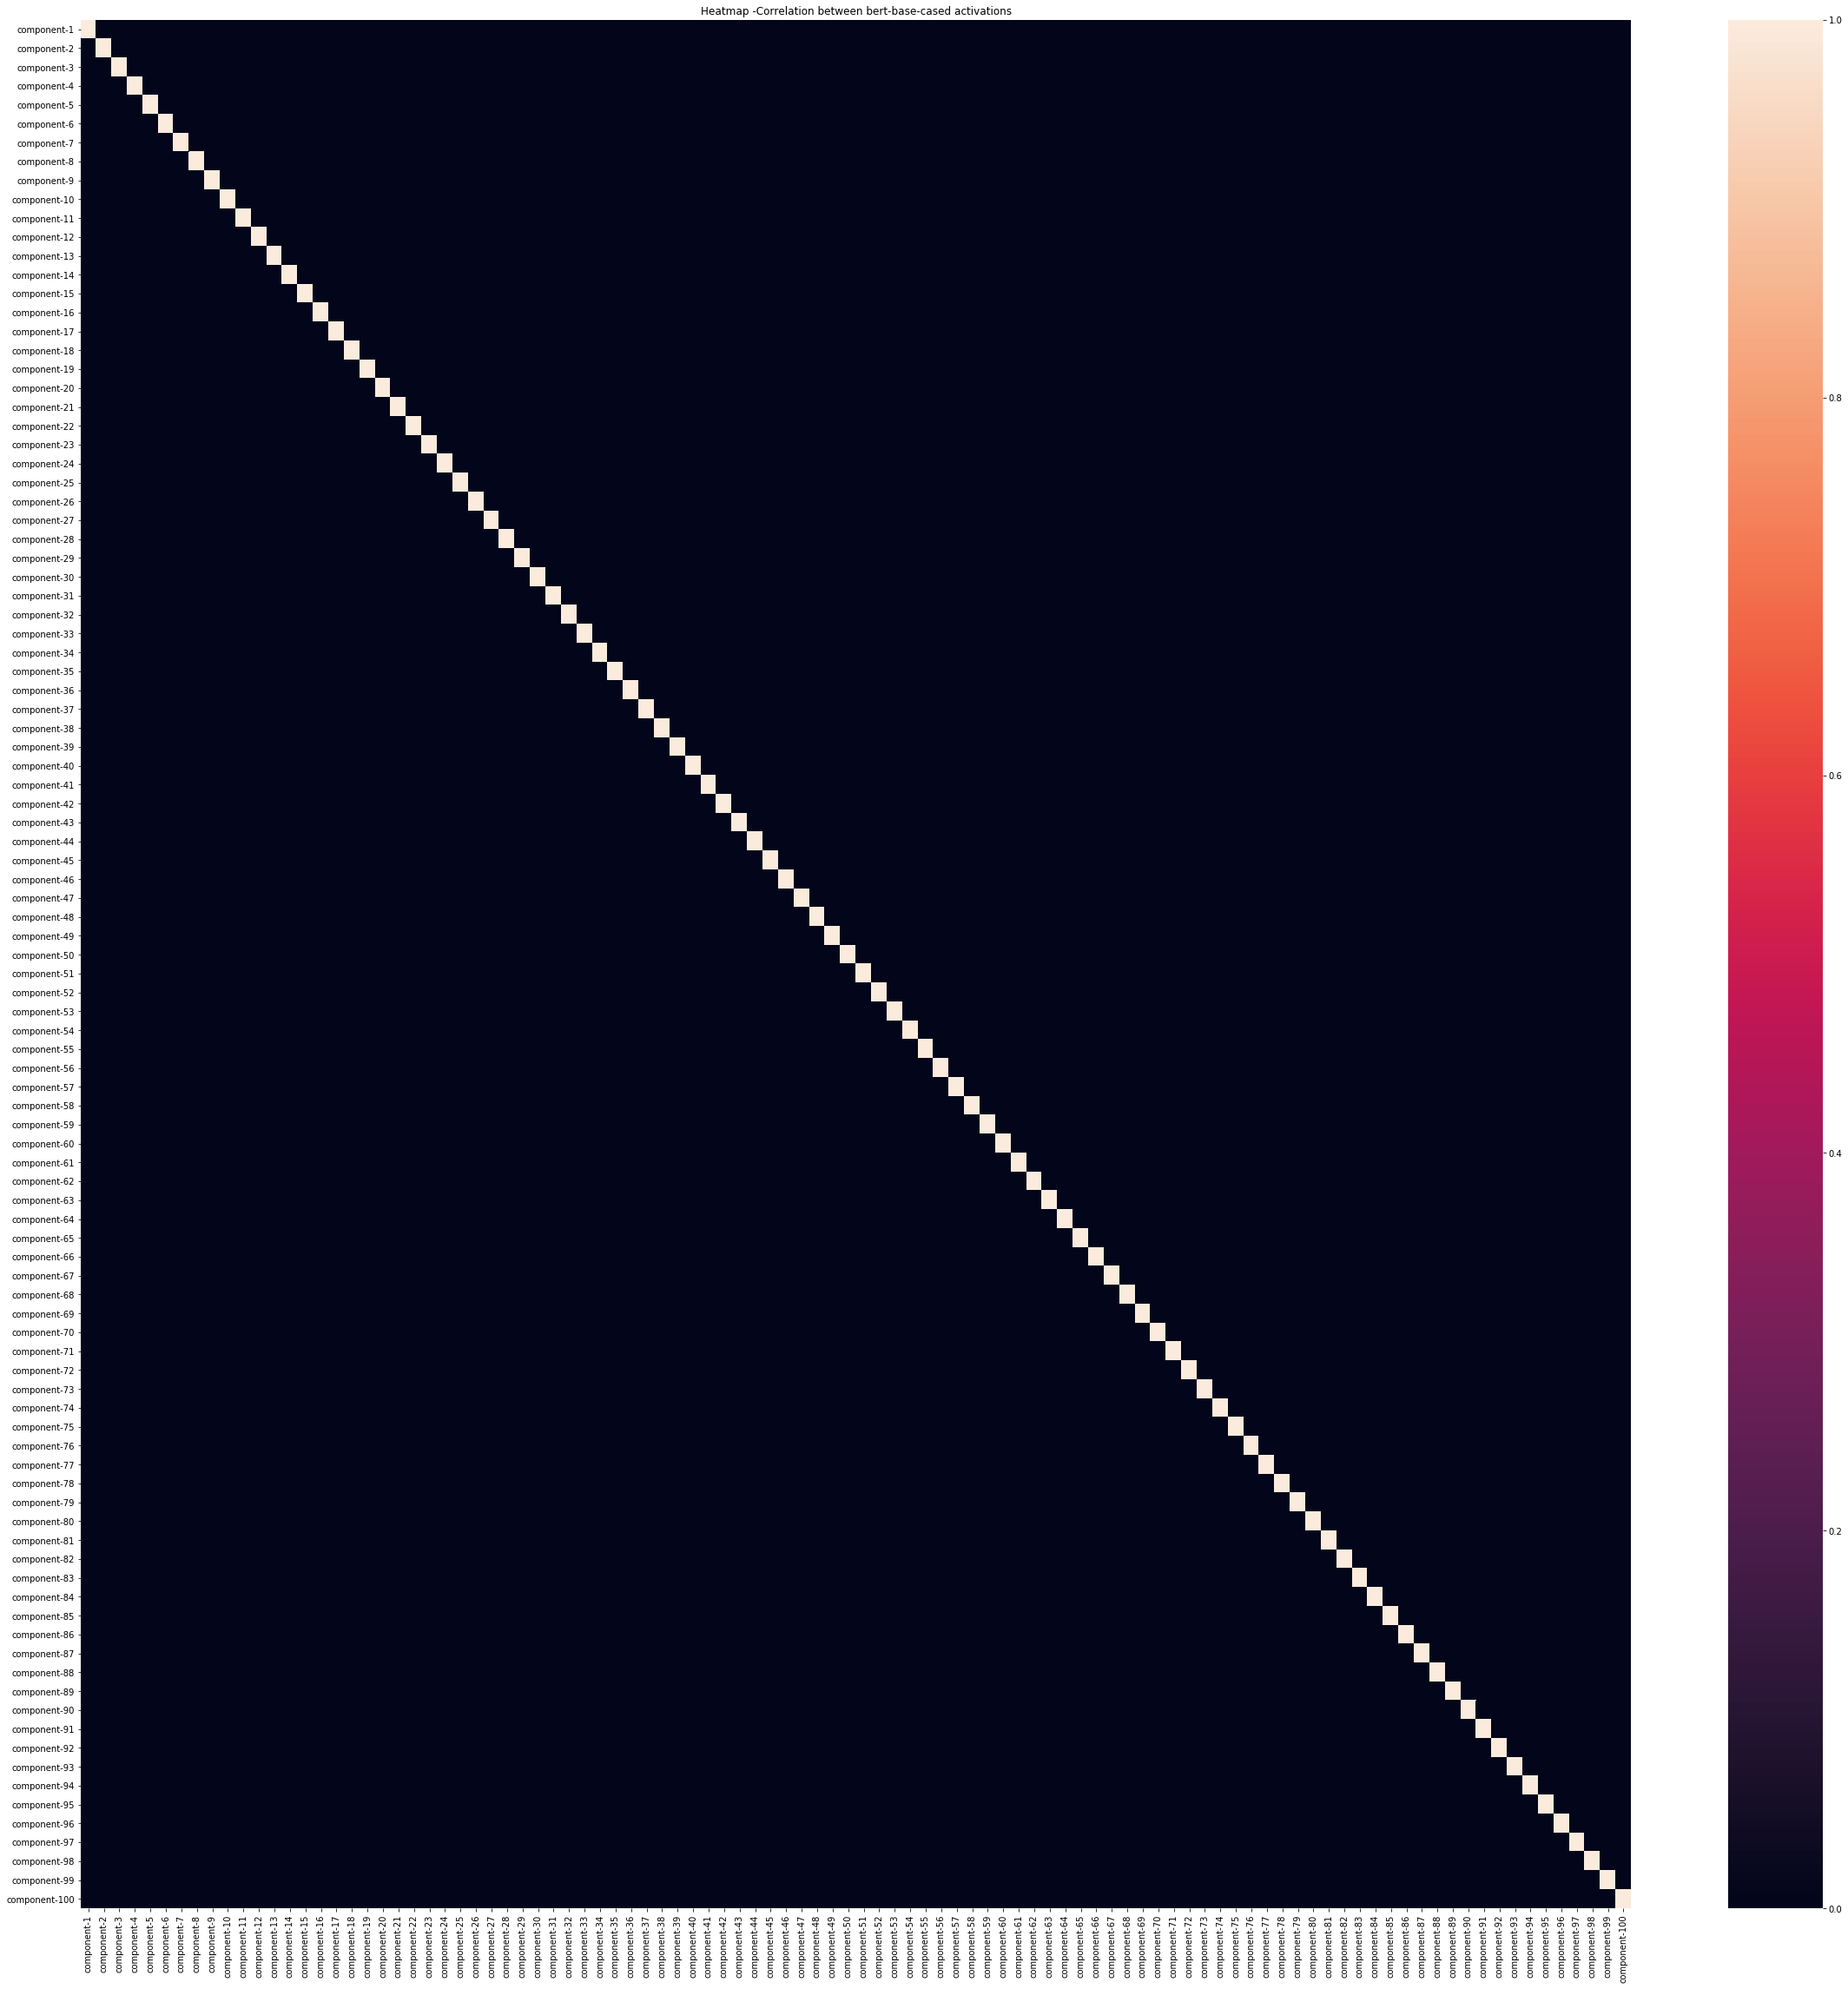

In [53]:
name = f'Correlation between {model_name} activations'
heat_map(pd.DataFrame(data_pca, columns=['component-{}'.format(index) for index in range(1, data_pca.shape[1]+1)]).corr(), aggregate=False, title=name, saving_path=None) #SAVING_FOLDER, name + '.png'


In [38]:
def heat_map(path_to_beta_maps, aggregate=False, title='', saving_path=None):
    if isinstance(path_to_beta_maps, str):
        data = np.load(path_to_beta_maps)
    else:
        data = path_to_beta_maps
    plt.figure(figsize=(40,40))
    if aggregate:
        data = aggregate_beta_maps(data, nb_layers=13, layer_size=768)
    sns.heatmap(data)
    plt.title('Heatmap -' + title)
    if saving_path is not None:
        plt.savefig(saving_path)
        plt.close()
    else:
        plt.show()
        

def cluster_map(path_to_beta_maps, title='', saving_path=None):
    if isinstance(path_to_beta_maps, str):
        data = np.load(path_to_beta_maps)
    else:
        data = path_to_beta_maps
    plt.figure(figsize=(40,40))
    sns.clustermap(data, row_cluster=False, method='ward', metric='cosine')
    plt.title('Heatmap -' + title)
    if saving_path is not None:
        plt.savefig(saving_path)
        plt.close()
    else:
        plt.show()

### Layer wise analysis

In [ ]:
layer_analysis_model_names = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0'
]

In [ ]:
analysis_layers = {
    'Hidden-layers': 'hidden-layer-*'}

In [ ]:
#data_full = reporting.get_model_data(model_names, language, OUTPUT_PATH)
#data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }



data_layers = reporting.get_layers_data(
                        layer_analysis_model_names, 
                        analysis=analysis_layers, 
                        language='english',
                        OUTPUT_PATH=OUTPUT_PATH
                        )

data_layers_to_plot = reporting.get_data_per_roi(
                                data_layers, 
                                atlas_maps,
                                labels,
                                analysis=analysis_layers, 
                                language='english', 
                                object_of_interest='Pearson_coeff',
                                attention_head_reordering=None,
                                PROJECT_PATH=PROJECT_PATH
                                )

In [ ]:
mean_layers = data_layers_to_plot['mean']
third_quartile_layers = data_layers_to_plot['third_quartile']
maximum_layers = data_layers_to_plot['maximum']

In [ ]:
reporting.vertical_plot(
                third_quartile_layers, 
                labels, 
                'Third_Quartile_Pearson-coeff_per_ROI',
                save_folder=None, 
                object_of_interest='Pearson_coeff', 
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,18), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='Pearson_coeff value', 
                model_name='Layers'
                )

### Attention-head wise analysis

In [ ]:
layer_analysis_model_names = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0'
]

In [ ]:
analysis_attention_heads = {
    'Specific-attention-heads': 'attention-layer-*_head-*'}

In [ ]:
data_attention_heads = reporting.get_layers_data(
                        layer_analysis_model_names, 
                        analysis=analysis_attention_heads, 
                        language='english',
                        OUTPUT_PATH=OUTPUT_PATH
                        )

In [ ]:
print(data_attention_heads['bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0']['Specific-attention-heads']['models'])

In [ ]:
attention_head_reordering = []

In [ ]:
data_attention_heads_to_plot = reporting.get_data_per_roi(
                                data_attention_heads, 
                                atlas_maps,
                                labels,
                                analysis=analysis_attention_heads, 
                                language='english', 
                                object_of_interest='Pearson_coeff',
                                attention_head_reordering=attention_head_reordering,
                                PROJECT_PATH=PROJECT_PATH
                                )

In [ ]:
mean_attention_heads = data_attention_heads_to_plot['mean']
third_quartile_attention_heads = data_attention_heads_to_plot['third_quartile']
maximum_attention_heads = data_attention_heads_to_plot['maximum']

In [ ]:
reporting.vertical_plot(
                third_quartile_attention_heads, 
                labels, 
                'Third_Quartile_Pearson-coeff_per_ROI',
                save_folder=None, 
                object_of_interest='Pearson_coeff', 
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,18), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='Pearson_coeff value', 
                model_name='Attention-heads'
                )

### Anovas

In [ ]:
model_names_attention_heads = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-9_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-8_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-7_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-6_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-5_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-4_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-3_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-2_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-1_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-12_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-11_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_59_attention-layer-10_head-1',
]

model_names_layers = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_59_hidden-layer-0',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-9',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-8',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-7',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-6',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-5',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-4',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-3',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-2',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-12',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-11',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-10',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-1',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_59_hidden-layer-0',
]


In [ ]:
anova_attention_heads = reporting.prepare_data_for_anova(
    model_names_attention_heads, 
    atlas_maps, 
    labels, 
    MASKER_PATH,
    object_of_interest='Pearson_coeff', 
    language='english',
    OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english'
    )

In [ ]:
saving_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/anovas/'
check_folder(saving_folder)

In [ ]:
anova_attention_heads.to_csv(os.path.join(saving_path, 'anova_attention_heads.csv'), index=False)

In [ ]:
anova_layers = reporting.prepare_data_for_anova(
    model_names_layers, 
    atlas_maps, 
    labels, 
    MASKER_PATH,
    object_of_interest='Pearson_coeff', 
    language='english',
    OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english'
    )

In [ ]:
anova_layers.to_csv(os.path.join(saving_path, 'anova_layers.csv'), index=False)